# "Cross-validation" des modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

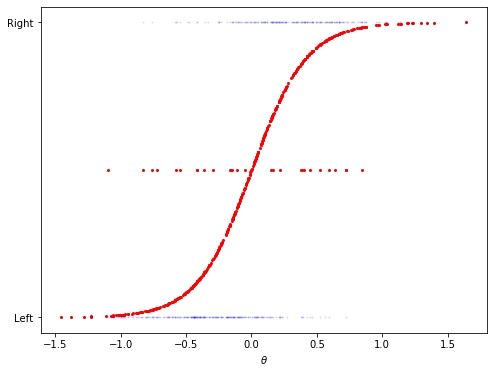

In [2]:
def get_data(
            N = 500,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/15,
            theta_std = np.pi/6):
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    # p0/2 + (1-p0)/
    flip = np.random.rand(N) > p0
    p = p*flip + .5*(1-flip)
    y = np.random.rand(N) < p
    return theta, p, y

theta, p, y = get_data()
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);



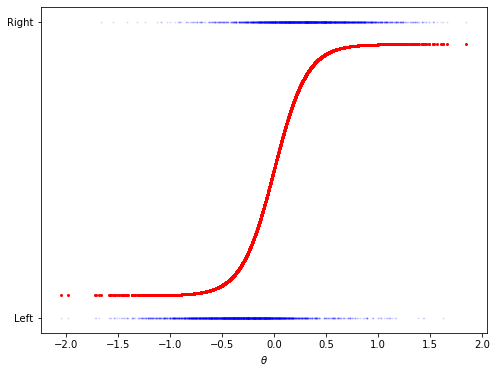

In [3]:
def get_data(
            N = 5000,
            p0 = 0.15,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6):
    
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y

theta, p, y = get_data()
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);



In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.nn import functional as F

In [5]:
logit0 = torch.nn.Linear(1, 1) 
logit0(torch.zeros(1)), torch.sigmoid(torch.zeros(1))

(tensor([0.4524], grad_fn=<AddBackward0>), tensor([0.5000]))

In [6]:
# Same as linear regression!
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1)    
        self.logit0 = torch.nn.Linear(1, 1) 
        
    def forward(self, x):
        p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
        out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
        return out

logistic_model = LogisticRegressionModel()

In [7]:
logistic_model.logit0.bias, logistic_model.linear.weight, logistic_model.linear.bias

(Parameter containing:
 tensor([-0.1534], requires_grad=True),
 Parameter containing:
 tensor([[0.1864]], requires_grad=True),
 Parameter containing:
 tensor([-0.6795], requires_grad=True))

https://pytorch.org/docs/stable/nn.html#bceloss

In [8]:
for p in  logistic_model.parameters(): print(p)

Parameter containing:
tensor([[0.1864]], requires_grad=True)
Parameter containing:
tensor([-0.6795], requires_grad=True)
Parameter containing:
tensor([[-0.2324]], requires_grad=True)
Parameter containing:
tensor([-0.1534], requires_grad=True)


In [9]:
criterion = torch.nn.BCELoss()

learning_rate = 0.005
num_epochs = 1e4
optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)

In [10]:
theta, p, y = get_data()
labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])

In [11]:
iter = 0
for epoch in range(int(num_epochs)):
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = logistic_model(Theta)

    # Calculate Loss: 
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    # Print Loss
    if epoch % (num_epochs//32) == 0 : 
        print(f"Iteration: {epoch}. Loss: {loss.item():.5f}.")

Iteration: 0. Loss: 0.69537.
Iteration: 312. Loss: 0.52952.
Iteration: 624. Loss: 0.47315.
Iteration: 936. Loss: 0.45716.
Iteration: 1248. Loss: 0.45224.
Iteration: 1560. Loss: 0.45045.
Iteration: 1872. Loss: 0.44934.
Iteration: 2184. Loss: 0.44833.
Iteration: 2496. Loss: 0.44750.
Iteration: 2808. Loss: 0.44692.
Iteration: 3120. Loss: 0.44652.
Iteration: 3432. Loss: 0.44627.
Iteration: 3744. Loss: 0.44611.
Iteration: 4056. Loss: 0.44602.
Iteration: 4368. Loss: 0.44596.
Iteration: 4680. Loss: 0.44594.
Iteration: 4992. Loss: 0.44592.
Iteration: 5304. Loss: 0.44592.
Iteration: 5616. Loss: 0.44592.
Iteration: 5928. Loss: 0.44591.
Iteration: 6240. Loss: 0.44591.
Iteration: 6552. Loss: 0.44591.
Iteration: 6864. Loss: 0.44591.
Iteration: 7176. Loss: 0.44591.
Iteration: 7488. Loss: 0.44591.
Iteration: 7800. Loss: 0.44591.
Iteration: 8112. Loss: 0.44591.
Iteration: 8424. Loss: 0.44591.
Iteration: 8736. Loss: 0.44591.
Iteration: 9048. Loss: 0.44591.
Iteration: 9360. Loss: 0.44591.
Iteration: 967

In [12]:
logistic_model.eval()

LogisticRegressionModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
  (logit0): Linear(in_features=1, out_features=1, bias=True)
)

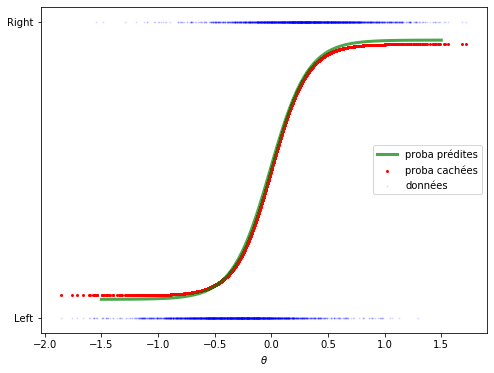

In [13]:
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend()


## validation

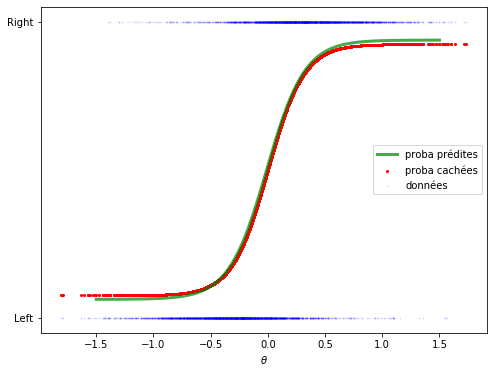

In [14]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])

plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend()
